In [1]:
%matplotlib inline

In [2]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display, clear_output

Введем некоторые константы

In [3]:
NUM_LABELS = 10
SEED = 42
INPUT_DIR = "./dz_data" # путь до данных для обучения
OUTPUT_FNAME = "submission.csv" # здесь должно быть записано имя выходного файла с ответами модели
CLS_LIST = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Загрузим данные для обучения и теста

In [4]:
X_train = np.load(f"{INPUT_DIR}/x_train.npy")
y_train = np.load(f"{INPUT_DIR}/y_train.npy")
X_test = np.load(f"{INPUT_DIR}/x_test.npy")

Посмотрим, как выглядят наши данные

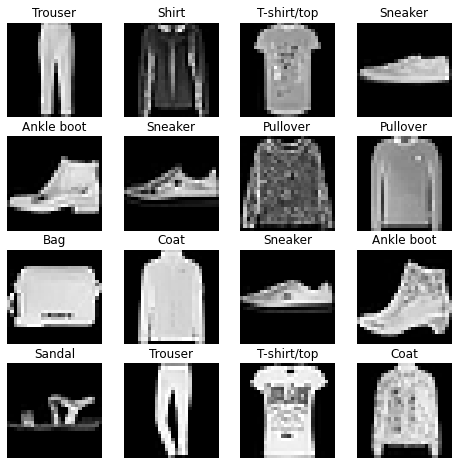

In [5]:
plt.figure(figsize=(8,8))
np.random.seed(SEED)
num_rc = 4
for i in range(16):
    idx = np.random.randint(X_train.shape[0])
    ax = plt.subplot(num_rc, num_rc, i + 1)
    ax.set_title(CLS_LIST[y_train[idx]])
    ax.set_axis_off()
    plt.imshow(X_train[idx].reshape(28,28), cmap='gray', vmin = 0, vmax = 255)

Разделим обучение на train и test

In [6]:
Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

Определим классы наших слоев

In [7]:
class Dense:
    def __init__(self, in_size, out_size):
        np.random.seed(1)
        self.W = np.random.normal(scale=0.1, size=(out_size, in_size))
        self.b = np.random.normal(scale=0.1, size=(out_size))
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def backward(self, dz, lr=0.001, lmbd = 0.00025):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # обновляем веса
        #self.W = self.W - lr * self.dW
        self.W = self.W - lr * (self.dW + lmbd * self.W)
        #self.b = self.b - lr * self.db
        self.b = self.b - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx
    
    def get_w(self):
        return self.W

In [8]:
class Max:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz

In [9]:
#Использовалась для сравнения ошибки на тестовой выборке
class Sigma:
    def forward(self, x):
        self.sigma = np.ones(x.shape[0]) / (1 + np.exp(-x + .00001))
        return np.ones(x.shape[0]) / (1 + np.exp(-x + .00001))
    
    def backward(self, dz, lr=0.1):
        return (1 - self.sigma) * self.sigma * dz

In [10]:
class Softmax:
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x)
        return exps / np.sum(exps)
    
    def backward(self, dz, lr=0.001):
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)

In [11]:
class CrossEntropy:
    
    def forward(self, y_true, y_hat, w_sqr, lmda):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum( y_true * np.log(y_hat)) + w_sqr * (lmda / 2)
    
    def backward(self, dz, lr=0.001):
        return dz * -1. * self.y_true / self.y_hat

Соберем сеть для классификации изображений

In [12]:
class FashionNet:
    
    def __init__(self):
        self.d1 = Dense(784, 200)
        self.rl1 = Max()
        self.d2 = Dense(200, 100)
        self.rl2 = Max()
        self.d3 = Dense(100, 50)
        self.rl3 = Max()
        self.d4 = Dense(50, 10)
        self.s = Softmax()
        
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.rl1.forward(net)
        net = self.d2.forward(net)
        net = self.rl2.forward(net)
        net = self.d3.forward(net)
        net = self.rl3.forward(net)
        net = self.d4.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr, lmbd):
        dz = self.s.backward(dz, lr)
        dz = self.d4.backward(dz, lr, lmbd)
        dz = self.rl3.backward(dz, lr)
        dz = self.d3.backward(dz, lr, lmbd)
        dz = self.rl2.backward(dz, lr)
        dz = self.d2.backward(dz, lr, lmbd)
        dz = self.rl1.backward(dz, lr)
        dz = self.d1.backward(dz, lr, lmbd)
        return dz
    
    def get_square_of_weights(self):
        square = np.sum(np.square(self.d1.get_w()))
        square += np.sum(np.square(self.d2.get_w()))
        square += np.sum(np.square(self.d3.get_w()))
        square += np.sum(np.square(self.d4.get_w()))
        return square
        
        

Предобработаем наши данные

In [13]:
X_train = X_train.astype('float')
Xm = np.mean(X_train, axis=0)
Xs = np.std(X_train, axis=0)

Xt_train_mod = (Xt_train - Xm) / (Xs + 0.0001)
Xt_test_mod = (Xt_test - Xm) / (Xs + 0.0001)
X_test_mod = (X_test - Xm) / (Xs + 0.0001)

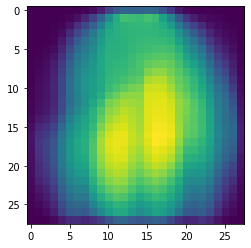

In [14]:
plt.imshow(Xm.reshape((28, 28)))

In [15]:
# заэнкодим наши ответы
t = OneHotEncoder(sparse=False)
yt_train_oh = t.fit_transform(yt_train.reshape(-1, 1))
yt_test_oh = t.transform(yt_test.reshape(-1, 1))

In [16]:
net = FashionNet()
loss = CrossEntropy()

Проверка обучаемости модели.

<IPython.core.display.Javascript object>


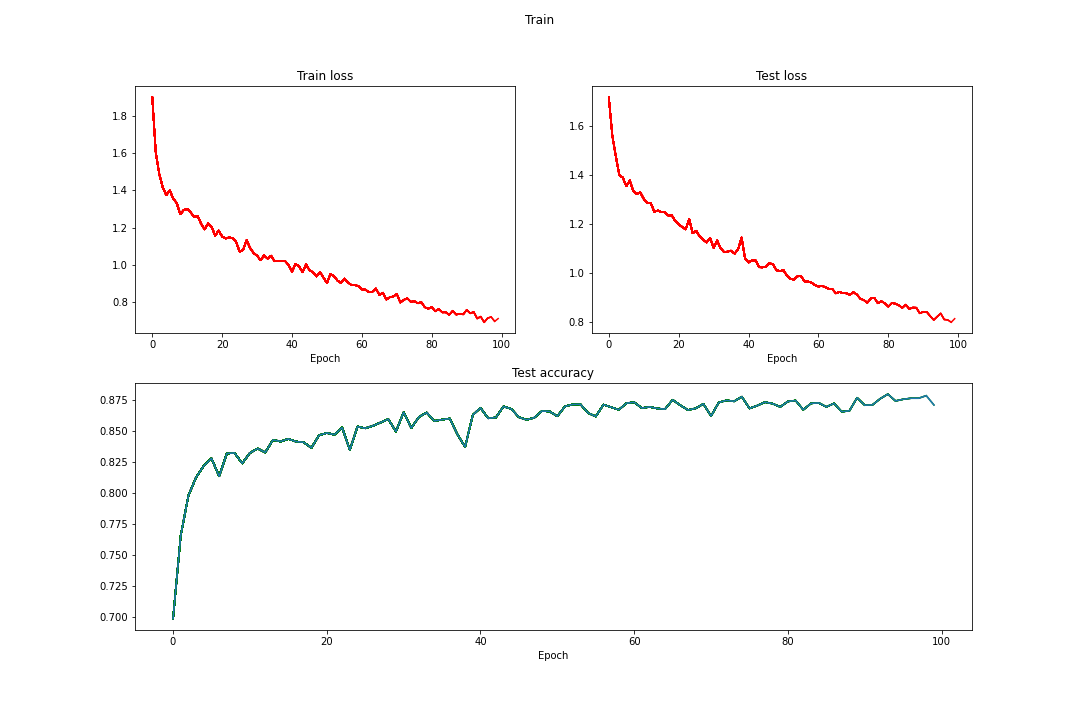

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
%matplotlib notebook
from tqdm.auto import tqdm

lr = 0.002

lmbd = 0.001

L_train_acc = [] # массив для хранения лоссов на обучении за эпоху
L_test_acc = [] # массив для хранения лоссов на отложенном сете
Acc_test_acc = [] # массив для хранения точности на отложенном сете за эпоху

plot_mod = True
if plot_mod:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Train')

for iter in tqdm(range(100)):
    # ЧАСТЬ 1:
    # проводим эпоху обучения, сохраняем средний лосс по всем примерам за эпоху
    # в переменной L_train_acc
    
    L_acc = 0.
    sh = list(range(Xt_train_mod.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    sh = sh[:2048]
    for i in range(len(sh)):
        x = Xt_train_mod[sh[i]]
        y = yt_train_oh[sh[i]]
        y_h = net.forward(x)
        w_sqr = net.get_square_of_weights()
        L = loss.forward(y, y_h, w_sqr, lmbd)
        L_acc += L
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr, lmbd)
    L_train_acc.append(L_acc / len(sh))
    
    # ЧАСТЬ 2:
    # Оцениваем сеть после одной эпохи на отложенной выборке
    # Сохраняем средний лосс в переменной L_test_acc
    # Сохраняем среднее значение accuracy в Acc_test_acc
    L_acc = 0.
    Acc = 0.
    for i in range(Xt_test_mod.shape[0]):
        x = Xt_test_mod[i]
        y = yt_test_oh[i]
        y_h = net.forward(x)
        w_sqr = net.get_square_of_weights()
        L = loss.forward(y, y_h, w_sqr, lmbd)
        L_acc += L
        Acc += np.array_equal(y_h == np.max(y_h), y)
        
    L_test_acc.append(L_acc / Xt_test_mod.shape[0])
    Acc_test_acc.append(Acc / Xt_test_mod.shape[0])
    
    if plot_mod:
        ax1.plot(range(iter+1), L_train_acc, 'r-')
        ax1.set_title('Train loss')
        ax1.set_xlabel('Epoch')
        fig.canvas.draw()
        
        ax2.plot(range(iter+1), L_test_acc, 'r-')
        ax2.set_title('Test loss')
        ax2.set_xlabel('Epoch')
        fig.canvas.draw() 
        
        ax3.plot(range(iter+1), Acc_test_acc, 'g-')
        ax3.set_title('Test accuracy')
        ax3.set_xlabel('Epoch')
        fig.canvas.draw()
    if(Acc_test_acc[-1] >= 0.9):
        break
    
plt.plot(Acc_test_acc)